## Binary classification example

In this example we show how the ecgxai package can be used to easily build a classification system for atrial fibrillation. We train the model on the PTB-XL dataset and use 'double residual' convolution resnet architecture. 

In [1]:
%load_ext autoreload
%autoreload 2
# We first import the required data utilities from the ecgxai package
from ecgxai.utils.dataset import PTBXLDataset
from ecgxai.utils.transforms import ApplyGain, ToTensor

# We also import some additional utilities from other packages for additionally functionality
from torch.utils.data import DataLoader
from torchvision.transforms import Compose

In [2]:
# The PTBXL dataset class automatically downloads and extract the PTB-XL 12 lead dataset
dataset = PTBXLDataset(
    # The path parameter defines where the data should be stored and were the data can be found in the future
    path="/workspace/misc/PTB_XL", 
    # We use the ApplyGain and ToTensor transformation (chained through the compose class)
    # to format the data into the desired format. In the case of PTB-XL, all the input data
    # is devided by 1000 in the ApplyGain transform to smoothen training (see the next cell for an example).
    transform = Compose([ApplyGain(), ToTensor()]),
    # The use_numpy parameter is set to True to speed up the loading of the data
    use_numpy=True,
    # As we are classifying 'Atrial fibrilation' in this example we tell the dataset to use the 
    # 'AF' label. 
    labels='AF'
)

# We then randomly split the dataset into a train and test set using a 90%-10% split
trainset, testset = dataset.train_test_split(ratio=0.1, shuffle=True)

print("Trainset:")
trainset.print_stats()

print("\n Testset: ")
testset.print_stats()

100%|██████████| 21837/21837 [00:00<00:00, 186045.27it/s]

Using downloaded and verified file: /workspace/misc/PTB_XL/PTB_XL.tar.gz
Trainset:


-- Dataset distribution -- 
Full size: 19653
["AF"] - Num entries: 1356 (6.9%)

 Testset: 
-- Dataset distribution -- 
Full size: 2184
["AF"] - Num entries: 158 (7.23%)


In [3]:
# The train and testset are then supplied to a pytorch dataloader which we can use to train the model
train_loader = DataLoader(
        trainset,
        batch_size=64,
        num_workers=8,
        shuffle=True
)

test_loader = DataLoader(
    testset,
    batch_size=64,
    num_workers=8
)

### Checking the data

The cell below plots the first lead of a sample from the dataset which we get using the __\_\_getitem\_\_()__ function which returns a dictionary. The raw ecg is stored under the 'waveform' key. 

dict_keys(['waveform', 'samplebase', 'gain', 'id', 'truebaseline_0', 'truebaseline_1', 'truebaseline_2', 'truebaseline_3', 'truebaseline_4', 'truebaseline_5', 'truebaseline_6', 'truebaseline_7', 'truebaseline_8', 'truebaseline_9', 'truebaseline_10', 'truebaseline_11', 'label'])


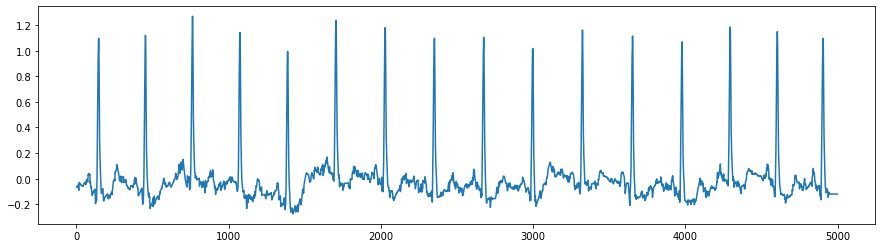

In [4]:
import matplotlib.pyplot as plt

example = trainset.__getitem__(0)

# We can plot the keys of the dictionary to see what is available in the standard dataset configuration. The 'truebaseline' 
# keys are used for baseline correction in some datasets. 
print(example.keys())

plt.figure(figsize=(15, 4))
plt.plot(example['waveform'][0])

### Initializing the model

We import the CNNDoubleResidual architecture from the ecgxai package and pass it the required hyperparameters to deal with our dataset (e.g. 12 channels, 5000 measurements per lead). We choose to subsample (half the spatial dimension) each layer to limit the required number of parameters. 

We also define adittional Sequential, Linear and Reshape modules to create a full pipeline that maps each ecg to a binary output. 

In [5]:
import torch.nn as nn
from ecgxai.network.doubleresidual.modules import CNNDoubleResidual, Reshape

# Initualize the double reisdual convolutional resnet
cnn = CNNDoubleResidual(
    num_layers=12,
    in_sample_dim=5000,
    in_channels=12,
    kernel_size=7,
    dropout_rate=0.1,
    sub_sample_every=1,
    double_channel_every=4,
    act_func=nn.ReLU(),
    batchnorm=True
)

# use the calculate_output_dim to see what size the output of the CNN is
cnn_output_dim, cnn_output_channels, cnn_output_samples = cnn.calculate_output_dim()

# We pass this calculated size to a linear layer that then maps the data to a single output per ecg, the final reshape
# gets rid of additional dimensions of the output tensor (e.g. B x L is reshaped to B)
class_model = nn.Sequential(
    cnn,
    nn.Linear(cnn_output_dim, 1),
    Reshape(-1)
)

### Printing the model archtecture using torchinfo

Using the __torchinfo__ package we can now easily show how the shape of the data changes through the various layers of the chosen architecture and approximately how much compute is needed for each operation. 

In [6]:
from torchinfo import summary

batch_size = 16
summary(class_model, input_size=(batch_size, 12, 5000), depth=50)


/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer (type:depth-idx)                                       Output Shape              Param #
Sequential                                                   [16]                      --
├─CNNDoubleResidual: 1-1                                     [16, 192]                 --
│    └─Sequential: 2-1                                       [16, 192]                 --
│    │    └─ResidualMaxPoolDoubleConvBlockForward: 3-1       [16, 12, 5000]            --
│    │    │    └─MaxPool1d: 4-1                              [16, 12, 5000]            --
│    │    │    └─Sequential: 4                               --                        --
│    │    │    │    └─BatchNorm1d: 5-1                       [16, 12, 5000]            24
│    │    └─ResidualMaxPoolDoubleConvBlockForward: 3         --                        --
│    │    │    └─Sequential: 4                               --                        --
│    │    │    │    └─ReLU: 5-2                              [16, 12, 5000]            --
│    

### Defining metrics

As this is a binary classification problem we would like to measure the performance of the model using common metrics such as AUROC, Precision, Recall, Accuracy and F1 score. We use the implemention of these metrics provided by the __TorchMetrics__ package. Each metric is wrapped using a __TorchMetricWrapper (TMW)__ provided by the ecgxai package. The TMW are intialized using a TorchMetric instance, the names of the model outputs that should be passed to the metric and an 'int_arg' parameter. The possible choices for output names can be found in the class definition of the classification system. In this case we use 'y_prob' (the predicted class probability) and 'label' (the true label of each sample). The int_args parameter is used to cast the 'label' output to an integer (originally float) which is required by the TorchMetric package. 

In [7]:
from ecgxai.utils.metrics import TMW
from torchmetrics import MetricCollection, AUROC, F1Score, Accuracy, Precision, Recall


metrics = MetricCollection(
    {
       'AUROC':  TMW(AUROC(), ['y_prob', 'label'], int_args=['label']),
       'Precision': TMW(Precision(), ['y_prob', 'label'], int_args=['label']),
       'Recall': TMW(Recall(), ['y_prob', 'label'], int_args=['label']),
       'Accuracy': TMW(Accuracy(), ['y_prob', 'label'], int_args=['label']),
       'F1': TMW(F1Score(), ['y_prob', 'label'], int_args=['label'])
    } 
)


/opt/conda/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


### Defining a loss function

As this is a binary classification problem we choose te commonly used BCEWithLogitsLoss from the torch package to train our model. This loss is wrapped using the ecgxai TorchWrapper (TW) class, which can be used similarly to the TMW class used to wrap the metrics. In this case we however use the 'y_hat' model output instead of the 'y_prob', as we would like the model output before applying a sigmoid. 

In [8]:
from ecgxai.utils.loss import TW

loss = TW(nn.BCEWithLogitsLoss(), ['y_hat', 'label'])

### Defining a classification system

Now we can define our Binary classification system. The system automatically handles the calculation of the loss and metrics. It also offers a variaty of automatic logging opperations for training, validation and testing. In this case we are only interested in the test_metrics, hence we only pass the defined metrics there. We also pass our model, the defined loss and a learning rate (lr) of 0.001. 

In [10]:
from ecgxai.systems.classification_system import ClassificationSystem

system = ClassificationSystem(
    lr=0.001,
    model=class_model,
    test_metrics=metrics,
    loss=loss,
    mode='binary'
)

['y_hat', 'label']


### Training and testing the model

To train the model we use __pytorch lighting__. We tell the pytorch lighting trainer object to train the model for 5 epochs and to save the model once done training. Additionally the trainer object will move all the required instances to the GPU if cuda is available to speed up training. 

In [11]:
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import ModelCheckpoint

trainer = pl.Trainer(
        max_epochs=5,
        gpus= 1 if torch.cuda.is_available() else None,
        logger=None,
        callbacks=[
            ModelCheckpoint(
                save_last=True
            ),
        ]
    )

trainer.fit(system, train_loader)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type             | Params
--------------------------------------------------
0 | test_metrics | MetricCollection | 0     
1 | loss         | TW               | 0     
2 | model        | Sequential       | 257 K 
--------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.030     Total estimated model params size (MB)
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /workspace/ecgxa

Training: 0it [00:00, ?it/s]

### Testing the model

Now all we need to do is test the model. 

In [12]:
trainer.test(model=system, dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/opt/conda/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_AUROC': 0.9975426197052002,
 'test_Accuracy': 0.9882909655570984,
 'test_F1': 0.9247804880142212,
 'test_Precision': 0.9445728063583374,
 'test_Recall': 0.9064620137214661,
 'test_loss': 0.03978169709444046}
--------------------------------------------------------------------------------


/opt/conda/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


[{'test_AUROC': 0.9975426197052002,
  'test_Accuracy': 0.9882909655570984,
  'test_F1': 0.9247804880142212,
  'test_Precision': 0.9445728063583374,
  'test_Recall': 0.9064620137214661,
  'test_loss': 0.03978169709444046}]